<a href="https://colab.research.google.com/github/Kavin-Balaji-NP-IT/CVNL_ASG/blob/main/Singapore_Changi_Luggage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Luggage Image Classificatio (CNN)

This notebook prototypes a PyTorch CNN that classifies airport luggage images (e.g., backpack / suitcase / carry-on) to support Changi Airport front‑of‑house triage and basic operational analytics.

Use case examples

Quickly flag likely carry‑on vs check‑in style items at assistance counters
Identify odd‑shaped / oversized luggage types for routing to the right queue
Provide simple category counts for service teams
Track chosen: Airport Luggage Category Classification (Roboflow dataset – Option 3)

In [ ]:
import os, glob
import sys
import json
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image




In [ ]:
class CFG:
    pass

cfg = CFG()
print("✓ cfg created")

✓ cfg created


1) Dataset Setup (Roboflow)

We use the Roboflow Airport Luggage dataset and download it into the runtime environment. After downloading, we verify the folder structure and (if needed) convert it into an ImageFolder layout so it can be loaded cleanly with torchvision.datasets. ImageFolder.

In [ ]:
!pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="FRoTkVjT19FabPTzndiW")
project = rf.workspace("cnn-0os6f").project("luggage-universe-hpssq")
dataset = project.version(1).download("multiclass")

cfg.DATA_DIR = dataset.location
print("DATA_DIR:", cfg.DATA_DIR)

loading Roboflow workspace...
loading Roboflow project...
DATA_DIR: /content/luggage-universe-1


In [ ]:
import os

print("Root:", cfg.DATA_DIR)
print("Root contents:", os.listdir(cfg.DATA_DIR))

for split in ["train", "valid", "test"]:
    split_path = os.path.join(cfg.DATA_DIR, split)
    print(f"\n{split.upper()} exists?", os.path.exists(split_path))
    if os.path.exists(split_path):
        items = os.listdir(split_path)
        print(f"{split.upper()} contents (first 20):", items[:20])


Root: /content/luggage-universe-1
Root contents: ['README.roboflow.txt', 'train', 'README.dataset.txt', 'valid']

TRAIN exists? True
TRAIN contents (first 20): ['0479_p_3_jpg.rf.432b37756a1d25ff93ff2c54fb073341.jpg', '0478_p_2_jpg.rf.b20a3ebb00fac7035dd9d02dcb03f408.jpg', '0459_p_4_jpg.rf.f34ee1ef5b367bb12e43e3875763a172.jpg', 'photo_2022-06-15_15-02-44-2-_jpg.rf.201c6be7e742fb0f184b21a9646766d4.jpg', '0455_p_4_jpg.rf.4eedcdf7a5d9fb78102c8fc123a0a73f.jpg', 'realsense17_JPG_jpg.rf.58eb333de9b2a99c87a55151c7945fb8.jpg', '0481_p_2_jpg.rf.283505e8d083a2709d0823feaa0e71e1.jpg', 'realsense9_JPG_jpg.rf.5f99e3f1284c61ecb173745ae8425281.jpg', 'realsense2_JPG_jpg.rf.ca0fe45ddaedb476695d4ebb872aae2f.jpg', '0472_p_2_jpg.rf.4015c7b4ca5366ac2ab8125d120b0e96.jpg', 'realsense8_JPG_jpg.rf.3bbfe9d8ab3a33ec9edf82111b5510bd.jpg', '0473_p_1_jpg.rf.5f0989d730dd3fe06c1f97afd1c0cde8.jpg', '0470_p_3_jpg.rf.4a13cc2bee75982f341ecdd5da81cf66.jpg', 'realsense17_JPG_jpg.rf.45a825419be64276f92bb94f1491e0cd.jpg', '04

In [ ]:
import pandas as pd
from pathlib import Path

csv_path = Path(cfg.DATA_DIR) / "train" / "_classes.csv"
df = pd.read_csv(csv_path)

class_cols = [c for c in df.columns if c != "filename"]
print("CSV path:", csv_path)
print("Classes:", class_cols)
print("Num classes:", len(class_cols))
print(df.head(3))

CSV path: /content/luggage-universe-1/train/_classes.csv
Classes: ['Hard case', 'Soft case']
Num classes: 2
                                            filename  Hard case  Soft case
0  0475_p_4_jpg.rf.0d32262dda2e2da3ab87a489cf0ebe...          1          0
1  realsense11_JPG_jpg.rf.3a62f76033c6acd932e4c29...          1          0
2  0459_p_4_jpg.rf.f34ee1ef5b367bb12e43e3875763a1...          1          0


In [ ]:


import pandas as pd

train_dir = os.path.join(cfg.DATA_DIR, "train")
valid_dir = os.path.join(cfg.DATA_DIR, "valid")

train_csv = os.path.join(train_dir, "_classes.csv")
valid_csv = os.path.join(valid_dir, "_classes.csv")

print("Train _classes.csv exists?", os.path.exists(train_csv), "|", train_csv)
print("Valid _classes.csv exists?", os.path.exists(valid_csv), "|", valid_csv)

# Load train CSV to see columns and classes
df_train = pd.read_csv(train_csv)
print("\nTrain CSV columns:", df_train.columns.tolist())
print("Train rows:", len(df_train))

# Class names = all columns except the filename column
filename_col = df_train.columns[0]
class_cols = df_train.columns[1:].tolist()
print("\nFilename column:", filename_col)
print("Class columns (your luggage categories):", class_cols)
print("Num classes:", len(class_cols))

df_train.head()

Train _classes.csv exists? True | /content/luggage-universe-1/train/_classes.csv
Valid _classes.csv exists? True | /content/luggage-universe-1/valid/_classes.csv

Train CSV columns: ['filename', 'Hard case', 'Soft case']
Train rows: 102

Filename column: filename
Class columns (your luggage categories): ['Hard case', 'Soft case']
Num classes: 2


,filename,Hard case,Soft case
0,0475_p_4_jpg.rf.0d32262dda2e2da3ab87a489cf0ebe...,1,0
1,realsense11_JPG_jpg.rf.3a62f76033c6acd932e4c29...,1,0
2,0459_p_4_jpg.rf.f34ee1ef5b367bb12e43e3875763a1...,1,0
3,0470_p_1_jpg.rf.144b0022bba58fff229642e584ebc1...,1,0
4,0462_p_4_jpg.rf.68ae1e7eb6f2674956af0d841063d5...,1,0


## 2) Prepare ImageFolder Structure

`ImageFolder` expects a folder layout like:

- `train/<class_name>/*.jpg`
- `valid/<class_name>/*.jpg`
- (optional) `test/<class_name>/*.jpg`

This section converts Roboflow’s exported labels into the above structure so the rest of the PyTorch pipeline is straightforward.


In [ ]:
# === CELL 5: convert Roboflow multiclass CSV -> ImageFolder structure ===
import os, shutil
import pandas as pd
from pathlib import Path

src_root = Path(cfg.DATA_DIR)
out_root = src_root.parent / (src_root.name + "_ImageFolder")

def convert_split(split):
    split_dir = src_root / split
    csv_path = split_dir / "_classes.csv"
    df = pd.read_csv(csv_path)

    filename_col = df.columns[0]
    class_cols = df.columns[1:].tolist()

    out_split = out_root / split
    out_split.mkdir(parents=True, exist_ok=True)

    moved = 0
    skipped = 0

    for _, row in df.iterrows():
        fname = row[filename_col]
        src_img = split_dir / fname
        if not src_img.exists():
            skipped += 1
            continue

        # pick the class where value == 1 (one-hot)
        label = None
        for c in class_cols:
            if int(row[c]) == 1:
                label = c
                break

        if label is None:
            skipped += 1
            continue

        dest_dir = out_split / label
        dest_dir.mkdir(parents=True, exist_ok=True)

        shutil.copy2(src_img, dest_dir / fname)
        moved += 1

    print(f"{split}: copied {moved} images into class folders, skipped {skipped}")

# build output dataset
out_root.mkdir(exist_ok=True)
convert_split("train")
convert_split("valid")

cfg.CLS_DIR = str(out_root)
print("\nNew ImageFolder dataset created at:", cfg.CLS_DIR)

# show structure
print("\nTrain folders:", os.listdir(os.path.join(cfg.CLS_DIR, "train")))
print("Valid folders:", os.listdir(os.path.join(cfg.CLS_DIR, "valid")))


train: copied 102 images into class folders, skipped 0
valid: copied 118 images into class folders, skipped 0

New ImageFolder dataset created at: /content/luggage-universe-1_ImageFolder

Train folders: ['Soft case', 'Hard case']
Valid folders: ['Soft case', 'Hard case']


## 3) Preprocessing and Augmentation

We apply standard vision preprocessing:
- **Resize / normalize** inputs for stable training
- **Augmentation** (flips, crops, color jitter, etc.) to improve generalization to new luggage photos


In [ ]:
# === CELL 5: define transforms and dataset path ===
from torchvision import transforms

# Path to the ImageFolder-style dataset you just created
cfg.CLS_DIR = "/content/luggage-universe-1_ImageFolder"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("Transforms ready")
print("CLS_DIR =", cfg.CLS_DIR)


Transforms ready
CLS_DIR = /content/luggage-universe-1_ImageFolder


In [ ]:
# === CELL 6: load ImageFolder datasets ===
import os
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(os.path.join(cfg.CLS_DIR, "train"), transform=train_transforms)
val_dataset   = ImageFolder(os.path.join(cfg.CLS_DIR, "valid"), transform=val_transforms)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)
print("Train samples:", len(train_dataset))
print("Valid samples:", len(val_dataset))

# Save for later cells
cfg.NUM_CLASSES = num_classes


Classes: ['Hard case', 'Soft case']
Num classes: 2
Train samples: 102
Valid samples: 118


In [ ]:
import warnings, random
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'\n{"="*60}')
print("Singapore Changi Airport - Luggage Classification System")
print(f'{"="*60}')
print("Device:", DEVICE)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("PyTorch Version:", torch.__version__)
print(f'{"="*60}\n')



Singapore Changi Airport - Luggage Classification System
Device: cuda
GPU: Tesla T4
PyTorch Version: 2.9.0+cu126



In [ ]:

import os

class Config:
    """Configuration for the luggage classification system"""

    # Dataset (ImageFolder)
    CLS_DIR = "/content/luggage-universe-1_ImageFolder"
    IMG_SIZE = 224
    BATCH_SIZE = 16
    NUM_WORKERS = 0

    # Model
    MODEL_NAME = "resnet18"
    PRETRAINED = True
    DROPOUT_RATE = 0.3
    USE_ATTENTION = False

    # Training
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    PATIENCE = 3
    WARMUP_EPOCHS = 0

    USE_MIXUP = False
    MIXUP_ALPHA = 0.2
    LABEL_SMOOTHING = 0.0
    GRADIENT_CLIP = 1.0
    USE_ADVANCED_AUG = False

    CONFIDENCE_THRESHOLD = 0.7

    SAVE_DIR = "/content/models"
    RESULTS_DIR = "/content/results"

cfg = Config()
os.makedirs(cfg.SAVE_DIR, exist_ok=True)
os.makedirs(cfg.RESULTS_DIR, exist_ok=True)

print("cfg ready")
print("CLS_DIR:", cfg.CLS_DIR)
print("MODEL:", cfg.MODEL_NAME, "| BATCH:", cfg.BATCH_SIZE)


cfg ready
CLS_DIR: /content/luggage-universe-1_ImageFolder
MODEL: resnet18 | BATCH: 16


In [ ]:
# Explore ImageFolder dataset structure
print('Dataset Structure:')
print('='*60)

data_root = Path(cfg.CLS_DIR)
splits = ['train', 'valid']

all_classes = set()
for split in splits:
    split_dir = data_root / split
    if split_dir.exists():
        classes = [d.name for d in split_dir.iterdir() if d.is_dir()]
        all_classes.update(classes)

        class_counts = {}
        for cls in classes:
            count = len(list((split_dir / cls).glob('*.jpg'))) + len(list((split_dir / cls).glob('*.png')))
            class_counts[cls] = count

        total = sum(class_counts.values())
        print(f'\n{split.upper()} Split: {total} images')
        for cls, count in sorted(class_counts.items()):
            print(f'  - {cls}: {count} images')

print(f'\nTotal Classes: {len(all_classes)}')
print(f'Classes: {sorted(all_classes)}')
print('='*60)


Dataset Structure:

TRAIN Split: 102 images
  - Hard case: 72 images
  - Soft case: 30 images

VALID Split: 118 images
  - Hard case: 89 images
  - Soft case: 29 images

Total Classes: 2
Classes: ['Hard case', 'Soft case']


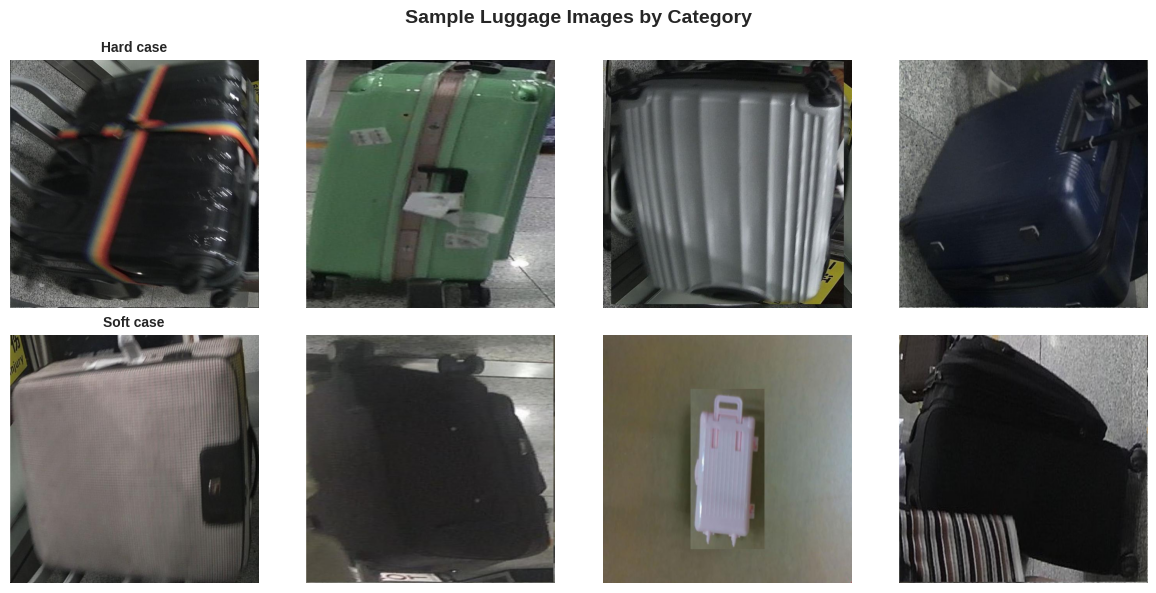

In [ ]:
# Visualize sample images
def visualize_samples(data_dir, num_samples=4):
    train_dir = Path(data_dir) / 'train'
    classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])

    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, num_samples, figsize=(12, 3*n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, -1)

    for i, cls in enumerate(classes):
        cls_dir = train_dir / cls
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png'))
        samples = random.sample(images, min(num_samples, len(images)))

        for j, img_path in enumerate(samples):
            img = Image.open(img_path).convert('RGB')
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{cls}', fontsize=10, fontweight='bold')

    plt.suptitle('Sample Luggage Images by Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{cfg.RESULTS_DIR}/dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(cfg.CLS_DIR)

In [ ]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((int(cfg.IMG_SIZE * 1.1), int(cfg.IMG_SIZE * 1.1))),
    transforms.RandomCrop(cfg.IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

val_transforms = transforms.Compose([
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print('✓ Data augmentation pipeline created')
print(f'  - Training: Advanced augmentation enabled')
print(f'  - Validation: Standard preprocessing')

✓ Data augmentation pipeline created
  - Training: Advanced augmentation enabled
  - Validation: Standard preprocessing


In [ ]:
# Classification dataset stats (ImageFolder)
from collections import Counter

print("Classes:", class_names)
print("Num classes:", num_classes)

train_targets = [y for _, y in train_dataset.samples]
counts = Counter(train_targets)

print("\nTrain class distribution:")
total = len(train_targets)
for idx, name in enumerate(class_names):
    c = counts.get(idx, 0)
    print(f"  - {name}: {c} ({100*c/total:.1f}%)")


Classes: ['Hard case', 'Soft case']
Num classes: 2

Train class distribution:
  - Hard case: 72 (70.6%)
  - Soft case: 30 (29.4%)


In [ ]:
print("Creating data loaders (ImageFolder)...")

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=torch.cuda.is_available()
)

print("✓ Data loaders created:")
print(f"  - Training batches:   {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")


Creating data loaders (ImageFolder)...
✓ Data loaders created:
  - Training batches:   6
  - Validation batches: 8


## 4) Model Design (CNN)

We use a **ResNet backbone** (transfer learning from ImageNet) with a custom classification head for luggage categories.
Optional improvements included in the code:
- Attention module (**CBAM**)
- Regularization such as **dropout**
- Stronger augmentation like **MixUp**


In [ ]:
class ChannelAttention(nn.Module):
    """Channel attention (Squeeze-and-Excitation)"""
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out.expand_as(x)

class SpatialAttention(nn.Module):
    """Spatial attention module"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, in_channels):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

print('Attention modules defined')

Attention modules defined


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class LuggageClassifier(nn.Module):
    """Advanced CNN for luggage classification"""

    def __init__(self, num_classes, model_name="resnet18", pretrained=True, dropout=0.3, use_attention=False):
        super().__init__()
        self.model_name = model_name
        self.use_attention = use_attention

        # Load backbone (torchvision)
        if model_name == "resnet50":
            weights = models.ResNet50_Weights.DEFAULT if pretrained else None
            backbone = models.resnet50(weights=weights)
            feature_dim = 2048
        elif model_name == "resnet34":
            weights = models.ResNet34_Weights.DEFAULT if pretrained else None
            backbone = models.resnet34(weights=weights)
            feature_dim = 512
        elif model_name == "resnet18":
            weights = models.ResNet18_Weights.DEFAULT if pretrained else None
            backbone = models.resnet18(weights=weights)
            feature_dim = 512
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        # Remove avgpool + fc
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        if use_attention:
            self.attention = CBAM(feature_dim)

        self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout / 2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        if self.use_attention:
            x = self.attention(x)
        x = self.global_pool(x).flatten(1)
        return self.classifier(x)

    def freeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = False

    def unfreeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = True

# Create model
model = LuggageClassifier(
    num_classes=num_classes,
    model_name=cfg.MODEL_NAME,
    pretrained=cfg.PRETRAINED,
    dropout=cfg.DROPOUT_RATE,
    use_attention=cfg.USE_ATTENTION
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created: {cfg.MODEL_NAME.upper()}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Attention: {'Enabled' if cfg.USE_ATTENTION else 'Disabled'}")


Model created: RESNET18
Total parameters: 11,308,354
Trainable parameters: 11,308,354
Attention: Disabled


In [ ]:

# MixUp augmentation
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Label smoothing loss
import torch.nn as nn
import torch.nn.functional as F
import torch

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = float(epsilon)

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        if n_classes <= 1:
            return F.cross_entropy(preds, target)

        log_preds = F.log_softmax(preds, dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.epsilon / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.epsilon)

        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))


In [ ]:
# Loss function (classification-style, no class weighting)
criterion = LabelSmoothingCrossEntropy(
    epsilon=cfg.LABEL_SMOOTHING
)

# Optimizer
optimizer = optim.AdamW(
    [
        {'params': model.backbone.parameters(), 'lr': cfg.LEARNING_RATE * 0.1},
        {'params': model.classifier.parameters(), 'lr': cfg.LEARNING_RATE}
    ],
    weight_decay=cfg.WEIGHT_DECAY
)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg.NUM_EPOCHS,
    eta_min=1e-6
)

print("Optimizer and scheduler configured")
print("Optimizer: AdamW")
print(f"Backbone LR: {cfg.LEARNING_RATE * 0.1}")
print(f"Classifier LR: {cfg.LEARNING_RATE}")
print("Scheduler: Cosine Annealing")


Optimizer and scheduler configured
Optimizer: AdamW
Backbone LR: 0.0001
Classifier LR: 0.001
Scheduler: Cosine Annealing


In [ ]:
class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.learning_rates = []

    def update(self, train_loss, train_acc, val_loss, val_acc, lr):
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        self.learning_rates.append(lr)


def train_one_epoch(model, loader, criterion, optimizer, epoch, use_mixup=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [Train]")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        if use_mixup and cfg.USE_MIXUP:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, cfg.MIXUP_ALPHA)

        optimizer.zero_grad()
        outputs = model(inputs)

        if use_mixup and cfg.USE_MIXUP:
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            loss = criterion(outputs, targets)

        loss.backward()
        if cfg.GRADIENT_CLIP > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.GRADIENT_CLIP)
        optimizer.step()

        running_loss += loss.item()

        if not (use_mixup and cfg.USE_MIXUP):
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_postfix({
                "loss": running_loss / (pbar.n + 1),
                "acc": 100.0 * correct / total
            })
        else:
            pbar.set_postfix({"loss": running_loss / (pbar.n + 1)})

    avg_loss = running_loss / len(loader)
    avg_acc = 100.0 * correct / total if total > 0 else 0.0
    return avg_loss, avg_acc


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Validation"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / len(loader), 100.0 * correct / total




```
# This is formatted as code
```

## 5) Training

We train the CNN and track:
- Training/validation **loss**
- Training/validation **accuracy**
- Learning rate schedule (if enabled)

The goal is to progressively improve generalization rather than only memorizing the training set.


## Training Loop

Multi-stage training: warmup with frozen backbone, then fine-tuning.

In [ ]:
# Initialize metrics
metrics = MetricsTracker()
best_val_metric = float("-inf")
best_model_path = os.path.join(cfg.SAVE_DIR, "best_model.pth")
patience_counter = 0

# Determine effective num_classes
effective_num_classes = getattr(cfg, "NUM_CLASSES", None)
if effective_num_classes is None:
    try:
        effective_num_classes = num_classes
    except:
        effective_num_classes = 1

# Build criterion safely
if effective_num_classes <= 1:
    print("⚠️ num_classes <= 1 detected → using plain CrossEntropyLoss (no label smoothing).")
    criterion = nn.CrossEntropyLoss()
else:
    print("✓ Using LabelSmoothingCrossEntropy")
    criterion = LabelSmoothingCrossEntropy(epsilon=cfg.LABEL_SMOOTHING)


use_label_smoothing = (effective_num_classes is not None and effective_num_classes > 1)

print(f'\n{"="*60}')
print("Starting Training")
print(f'{"="*60}\n')

if not use_label_smoothing:
    print("Detected num_classes <= 1 → disabling label smoothing (prevents ZeroDivisionError).\n")

# Stage 1: Warmup with frozen backbone
print("Stage 1: Training classifier head (backbone frozen)")
model.freeze_backbone()

for epoch in range(cfg.WARMUP_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, use_mixup=False)
    val_loss, val_acc = validate(model, val_loader, criterion)

    current_lr = optimizer.param_groups[0]["lr"]
    metrics.update(train_loss, train_acc, val_loss, val_acc, current_lr)

    print(f"Epoch {epoch+1}/{cfg.WARMUP_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}\n")

    scheduler.step()

# Stage 2: Fine-tune entire model
print("\nStage 2: Fine-tuning entire model")
model.unfreeze_backbone()

optimizer = optim.AdamW(
    [
        {"params": model.backbone.parameters(), "lr": cfg.LEARNING_RATE * 0.01},
        {"params": model.classifier.parameters(), "lr": cfg.LEARNING_RATE * 0.1},
    ],
    weight_decay=cfg.WEIGHT_DECAY,
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max(1, cfg.NUM_EPOCHS - cfg.WARMUP_EPOCHS),
    eta_min=1e-7,
)

for epoch in range(cfg.WARMUP_EPOCHS, cfg.NUM_EPOCHS):
    use_mixup_now = bool(getattr(cfg, "USE_MIXUP", False)) and use_label_smoothing

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, use_mixup=use_mixup_now)
    val_loss, val_acc = validate(model, val_loader, criterion)

    current_lr = optimizer.param_groups[1]["lr"]
    metrics.update(train_loss, train_acc, val_loss, val_acc, current_lr)

    print(f"Epoch {epoch+1}/{cfg.NUM_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}")

    # If accuracy is meaningless (num_classes<=1), track best by lowest val_loss instead.
    if use_label_smoothing:
        current_metric = val_acc
        metric_name = "Val Acc"
    else:
        current_metric = -val_loss
        metric_name = "Val Loss"

    if current_metric > best_val_metric:
        best_val_metric = current_metric
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "val_loss": val_loss,
                "class_names": class_names if "class_names" in globals() else None,
            },
            best_model_path,
        )
        print(f"  ✓ New best model saved! ({metric_name}: {val_acc:.2f}% | Val Loss: {val_loss:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{cfg.PATIENCE})")

    print()

    if patience_counter >= cfg.PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

    scheduler.step()

print(f'\n{"="*60}')
print("Training Complete!")
if use_label_smoothing:
    print(f"Best Validation Accuracy: {best_val_metric:.2f}%")
else:
    print("Note: num_classes <= 1, so accuracy is not meaningful; best model tracked by lowest validation loss.")
print(f'{"="*60}\n')


✓ Using LabelSmoothingCrossEntropy

Starting Training

Stage 1: Training classifier head (backbone frozen)

Stage 2: Fine-tuning entire model


Epoch 1/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.6058 | Train Acc: 70.83%
  Val Loss:   0.6008 | Val Acc:   75.42%
  LR: 0.000100
  ✓ New best model saved! (Val Acc: 75.42% | Val Loss: 0.6008)



Epoch 2/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.5337 | Train Acc: 71.88%
  Val Loss:   0.5896 | Val Acc:   75.42%
  LR: 0.000090
  No improvement (1/3)



Epoch 3/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.5429 | Train Acc: 68.75%
  Val Loss:   0.5819 | Val Acc:   75.42%
  LR: 0.000065
  No improvement (2/3)



Epoch 4/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.5267 | Train Acc: 68.75%
  Val Loss:   0.5786 | Val Acc:   75.42%
  LR: 0.000035
  No improvement (3/3)

Early stopping triggered after 4 epochs

Training Complete!
Best Validation Accuracy: 75.42%



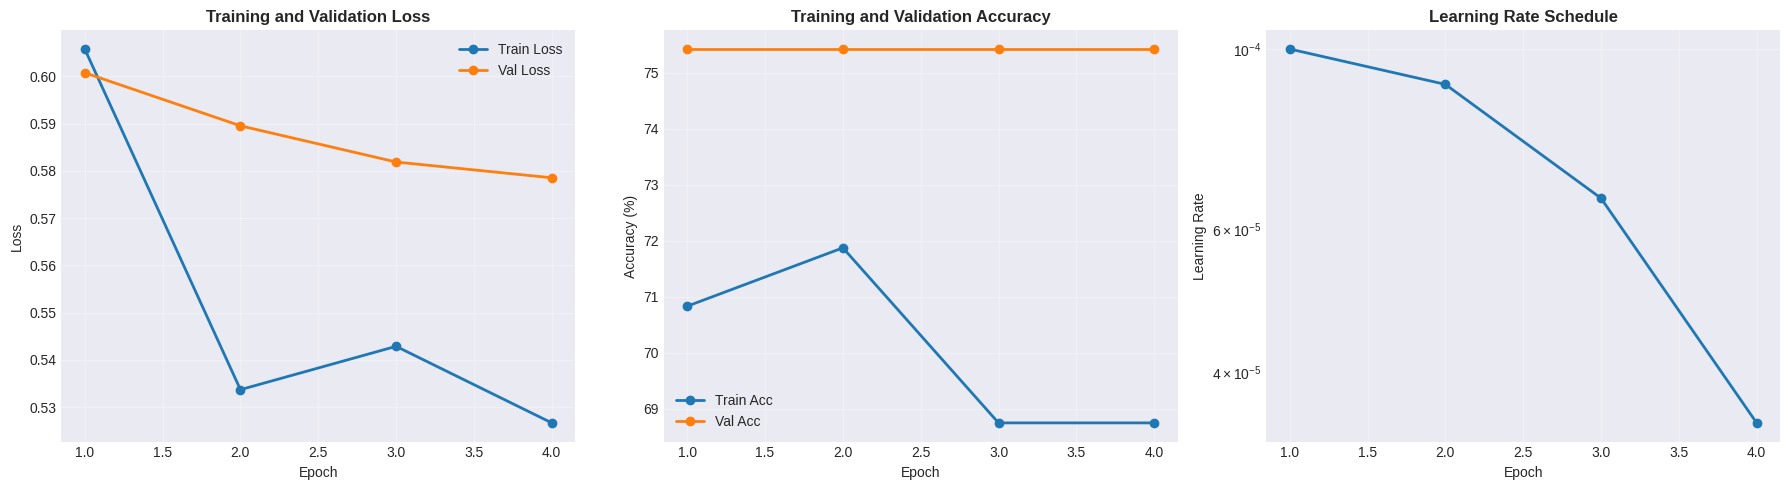

✓ Training curves saved


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs = list(range(1, len(metrics.train_losses) + 1))

# Loss
axes[0].plot(epochs, metrics.train_losses, label='Train Loss', linewidth=2, marker='o')
axes[0].plot(epochs, metrics.val_losses,   label='Val Loss',   linewidth=2, marker='o')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, metrics.train_accs, label='Train Acc', linewidth=2, marker='o')
axes[1].plot(epochs, metrics.val_accs,   label='Val Acc',   linewidth=2, marker='o')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(epochs, metrics.learning_rates, linewidth=2, marker='o')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule', fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{cfg.RESULTS_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Training curves saved')


In [ ]:
print(len(metrics.train_losses), metrics.train_losses)
print(len(metrics.val_losses), metrics.val_losses)
print(len(metrics.train_accs), metrics.train_accs)
print(len(metrics.val_accs), metrics.val_accs)

4 [0.6058054069677988, 0.5337053636709849, 0.5428751160701116, 0.5266721795002619]
4 [0.6007817201316357, 0.5895541124045849, 0.5818940475583076, 0.5785519666969776]
4 [70.83333333333333, 71.875, 68.75, 68.75]
4 [75.42372881355932, 75.42372881355932, 75.42372881355932, 75.42372881355932]


In [ ]:
print("Loading best model...")

print(f"Looking for checkpoint at: {best_model_path}")

if not os.path.exists(best_model_path):
    print(" Best model checkpoint not found.")
    print("Fix: re-run training and ensure the save block runs at least once.")
else:
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    val_acc = checkpoint.get("val_acc", None)
    val_loss = checkpoint.get("val_loss", None)

    if val_acc is not None:
        print(f"✓ Best model loaded (Val Acc: {val_acc:.2f}%)\n")
    elif val_loss is not None:
        print(f"✓ Best model loaded (Val Loss: {val_loss:.4f})\n")
    else:
        print("✓ Best model loaded\n")


Loading best model...
Looking for checkpoint at: /content/models/best_model.pth
✓ Best model loaded (Val Acc: 75.42%)



## 6) Evaluation (Accuracy, Precision, Recall, F1, Confusion Matrix)

We evaluate the trained model using:
- **Accuracy**
- **Precision / Recall / F1-score** (weighted)
- **Confusion matrix** to inspect which luggage classes are commonly mixed up

> Note: If the dataset does not include a `/test` split, this notebook evaluates on the **validation** set (and prints a warning). If you create a proper test split, use it here for final reporting.


In [ ]:
eval_loader = val_loader
eval_name = "Validation"

eval_dataset = eval_loader.dataset

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "predictions": all_preds,
        "labels": all_labels,
        "probabilities": all_probs,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "support": support,
        "confusion_matrix": cm
    }


# Run evaluation
results = evaluate_model(model, eval_loader)

print(f'\n{"="*60}')
print(f'{eval_name} Set Performance')
print(f'{"="*60}')
print(f'Accuracy:  {results["accuracy"]*100:.2f}%')
print(f'Precision: {results["precision"]*100:.2f}%')
print(f'Recall:    {results["recall"]*100:.2f}%')
print(f'F1-Score:  {results["f1"]*100:.2f}%')
print(f'{"="*60}\n')

val_results = results


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]


Validation Set Performance
Accuracy:  75.42%
Precision: 56.89%
Recall:    75.42%
F1-Score:  64.86%



In [ ]:


print("Per-Class Performance Metrics:")
print("=" * 80)
print(f'{"Class":<20} {"Precision":<12} {"Recall":<12} {"F1-Score":<12} {"Support":<10}')
print("=" * 80)

n = min(
    len(class_names),
    len(test_results["precision_per_class"]),
    len(test_results["recall_per_class"]),
    len(test_results["f1_per_class"]),
    len(test_results["support"])
)

for i in range(n):
    cls = class_names[i]
    print(
        f"{cls:<20} {test_results['precision_per_class'][i]:.4f}      "
        f"{test_results['recall_per_class'][i]:.4f}      "
        f"{test_results['f1_per_class'][i]:.4f}      "
        f"{int(test_results['support'][i]):<10}"
    )

print("=" * 80)
print(
    f"{'Weighted Avg':<20} {test_results['precision']:.4f}      "
    f"{test_results['recall']:.4f}      "
    f"{test_results['f1']:.4f}      "
    f"{len(test_results['labels']):<10}"
)
print("=" * 80 + "\n")

# Save to CSV
metrics_df = pd.DataFrame({
    "Class": class_names[:n],
    "Precision": test_results["precision_per_class"][:n],
    "Recall": test_results["recall_per_class"][:n],
    "F1-Score": test_results["f1_per_class"][:n],
    "Support": test_results["support"][:n],
})
metrics_df.to_csv(f"{cfg.RESULTS_DIR}/per_class_metrics.csv", index=False)
print("✓ Metrics saved to CSV")


Per-Class Performance Metrics:
Class                Precision    Recall       F1-Score     Support   
Hard case            0.7542      1.0000      0.8599      89        
Soft case            0.0000      0.0000      0.0000      29        
Weighted Avg         0.5689      0.7542      0.6486      118       

✓ Metrics saved to CSV


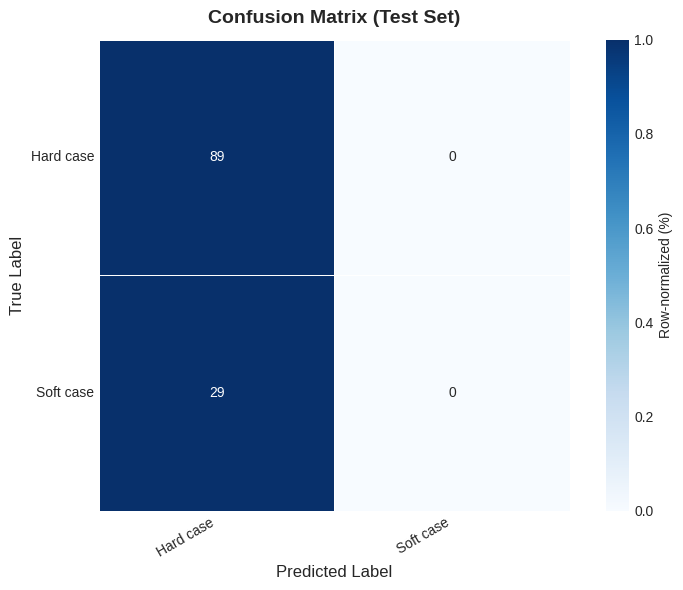

✓ Confusion matrix saved to: /content/results/confusion_matrix.png


In [ ]:

cm = test_results["confusion_matrix"]

# Safe row-normalization (avoid divide-by-zero -> NaN)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Row-normalized (%)"}
)

plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight="bold", pad=12)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(f"{cfg.RESULTS_DIR}/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print("✓ Confusion matrix saved to:", f"{cfg.RESULTS_DIR}/confusion_matrix.png")


## 7) Error / Confidence Analysis

To understand model behaviour beyond a single score, we inspect:
- **Prediction confidence** distribution
- **Misclassified examples** to identify visually similar categories or background noise


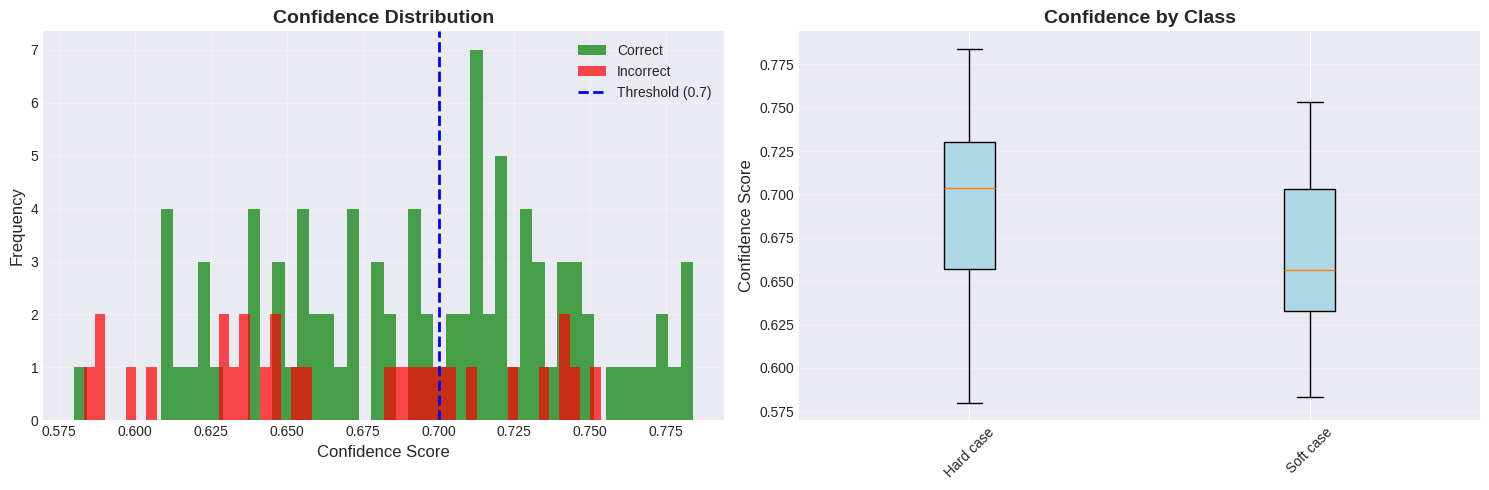


Confidence Statistics:
Correct predictions:
  Mean: 0.6955
  Median: 0.7037

Incorrect predictions:
  Mean: 0.6680
  Median: 0.6566


In [ ]:
# Confidence analysis
max_probs = np.max(test_results['probabilities'], axis=1)
correct_mask = test_results['predictions'] == test_results['labels']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(max_probs[correct_mask], bins=50, alpha=0.7, label='Correct', color='green')
axes[0].hist(max_probs[~correct_mask], bins=50, alpha=0.7, label='Incorrect', color='red')
axes[0].axvline(cfg.CONFIDENCE_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({cfg.CONFIDENCE_THRESHOLD})')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by class
confidence_by_class = [max_probs[test_results['labels'] == i] for i in range(len(class_names))]
bp = axes[1].boxplot(confidence_by_class, labels=class_names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_ylabel('Confidence Score', fontsize=12)
axes[1].set_title('Confidence by Class', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{cfg.RESULTS_DIR}/confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nConfidence Statistics:')
print(f'{"="*60}')
print(f'Correct predictions:')
print(f'  Mean: {np.mean(max_probs[correct_mask]):.4f}')
print(f'  Median: {np.median(max_probs[correct_mask]):.4f}')
if np.sum(~correct_mask) > 0:
    print(f'\nIncorrect predictions:')
    print(f'  Mean: {np.mean(max_probs[~correct_mask]):.4f}')
    print(f'  Median: {np.median(max_probs[~correct_mask]):.4f}')
print(f'{"="*60}')

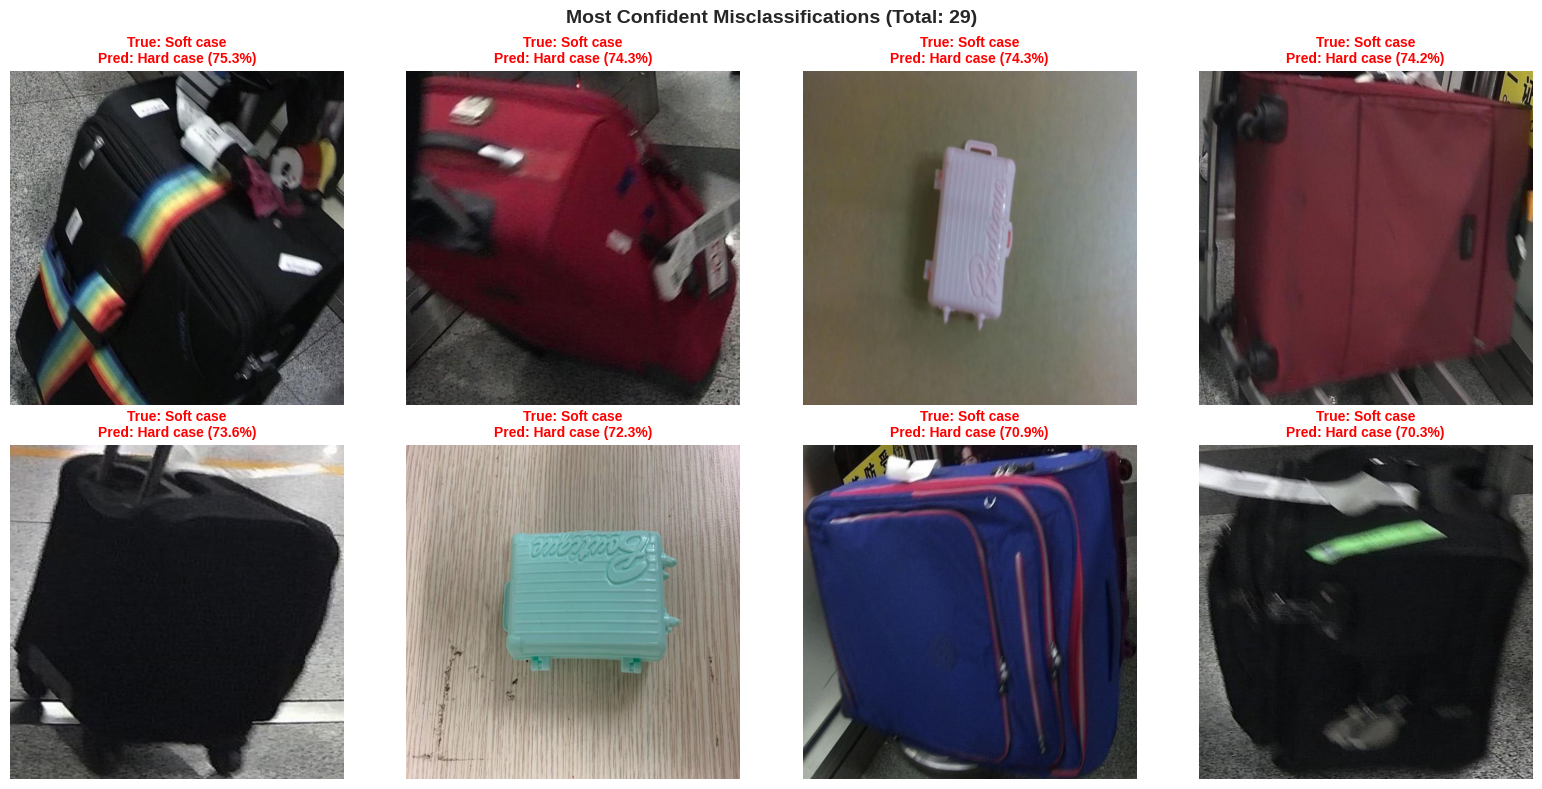

✓ Misclassifications: 29 / 118 (24.6%)


In [ ]:
# Visualize misclassifications
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

test_dataset = val_loader.dataset
mis_idx = np.where(test_results["predictions"] != test_results["labels"])[0]

if len(mis_idx) == 0:
    print("✓ No misclassifications found!")
else:
    # confidence level of the wrong predicted class
    confs = np.array([
        test_results["probabilities"][i][test_results["predictions"][i]]
        for i in mis_idx
    ])
    mis_idx = mis_idx[np.argsort(confs)[::-1]]  # most confident mistakes

    num_samples = min(8, len(mis_idx))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for plot_i, result_i in enumerate(mis_idx[:num_samples]):
        img_path = None
        if hasattr(test_dataset, "samples"):
            img_path = test_dataset.samples[result_i][0]
        elif hasattr(test_dataset, "image_paths"):
            img_path = test_dataset.image_paths[result_i]
        else:
            img_path = None

        if img_path is not None:
            img = Image.open(img_path).convert("RGB")
        else:
            img_tensor, _ = test_dataset[result_i]
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            img = (img * 0.225) + 0.485 # image for display
            img = np.clip(img, 0, 1)

        true_label = int(test_results["labels"][result_i])
        pred_label = int(test_results["predictions"][result_i])
        confidence = float(test_results["probabilities"][result_i][pred_label]) * 100

        axes[plot_i].imshow(img)
        axes[plot_i].axis("off")
        axes[plot_i].set_title(
            f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)",
            fontsize=10,
            color="red",
            fontweight="bold"
        )

    for j in range(num_samples, 8):
        axes[j].axis("off")

    plt.suptitle(
        f"Most Confident Misclassifications (Total: {len(mis_idx)})",
        fontsize=14,
        fontweight="bold"
    )
    plt.tight_layout()
    plt.savefig(f"{cfg.RESULTS_DIR}/misclassifications.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f'✓ Misclassifications: {len(mis_idx)} / {len(test_results["labels"])} ({len(mis_idx)/len(test_results["labels"])*100:.1f}%)')


## 8) Simple Deployment Pipeline (Inference)

This final section packages the trained model into a small inference class that:
1) Loads the checkpoint
2) Applies the same preprocessing
3) Runs prediction and returns the luggage class + confidence

This makes it easy to plug the model into a prototype UI or a counter‑support workflow.


## Deployment Pipeline

Production-ready inference system for Singapore Changi Airport operations.

In [ ]:
class LuggageClassificationPipeline:
    """Production inference pipeline"""

    def __init__(self, model, class_names, confidence_threshold=0.7, device=None):
        self.model = model
        self.class_names = class_names
        self.confidence_threshold = confidence_threshold
        self.device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def classify_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)[0]
            confidence, predicted_idx = torch.max(probabilities, 0)

        predicted_class = self.class_names[predicted_idx.item()]
        confidence_score = confidence.item()
        is_reliable = confidence_score >= self.confidence_threshold

        k = min(3, probabilities.numel(), len(self.class_names))
        topk_probs, topk_indices = torch.topk(probabilities, k)
        top3_predictions = [
            {"class": self.class_names[idx.item()], "confidence": prob.item()}
            for prob, idx in zip(topk_probs, topk_indices)
        ]

        return {
            "predicted_class": predicted_class,
            "confidence": confidence_score,
            "is_reliable": is_reliable,
            "top3_predictions": top3_predictions,
            "recommendation": self._get_recommendation(predicted_class, confidence_score),
        }

    def _get_recommendation(self, predicted_class, confidence):
        if confidence < self.confidence_threshold:
            return {
                "action": "MANUAL_REVIEW",
                "message": f"Low confidence ({confidence:.1%}). Manual inspection recommended.",
                "priority": "HIGH",
            }
        return {
            "action": "STANDARD_PROCESSING",
            "message": f"Classified as {predicted_class}. Standard processing protocol.",
            "priority": "NORMAL",
        }

# Create pipeline
pipeline = LuggageClassificationPipeline(
    model=model,
    class_names=class_names,
    confidence_threshold=cfg.CONFIDENCE_THRESHOLD,
    device=DEVICE
)

print("✓ Deployment pipeline created")
print(f"  - Confidence threshold: {cfg.CONFIDENCE_THRESHOLD}")
print(f"  - Classes: {', '.join(class_names)}")


✓ Deployment pipeline created
  - Confidence threshold: 0.7
  - Classes: Hard case, Soft case


## 9) How to Run

1. Run cells top‑to‑bottom.
2. Dataset download + conversion creates the expected folder layout.
3. Train the model (training loop).
4. Evaluate metrics + confusion matrix.
5. Use the deployment pipeline cell for inference on new images.

## 10) References

- Roboflow Airport Luggage dataset (Option 3)
- PyTorch / Torchvision documentation (ImageFolder, transforms, pretrained ResNet)
- CBAM attention module (for optional attention improvement)
- MixUp augmentation (optional regularization)


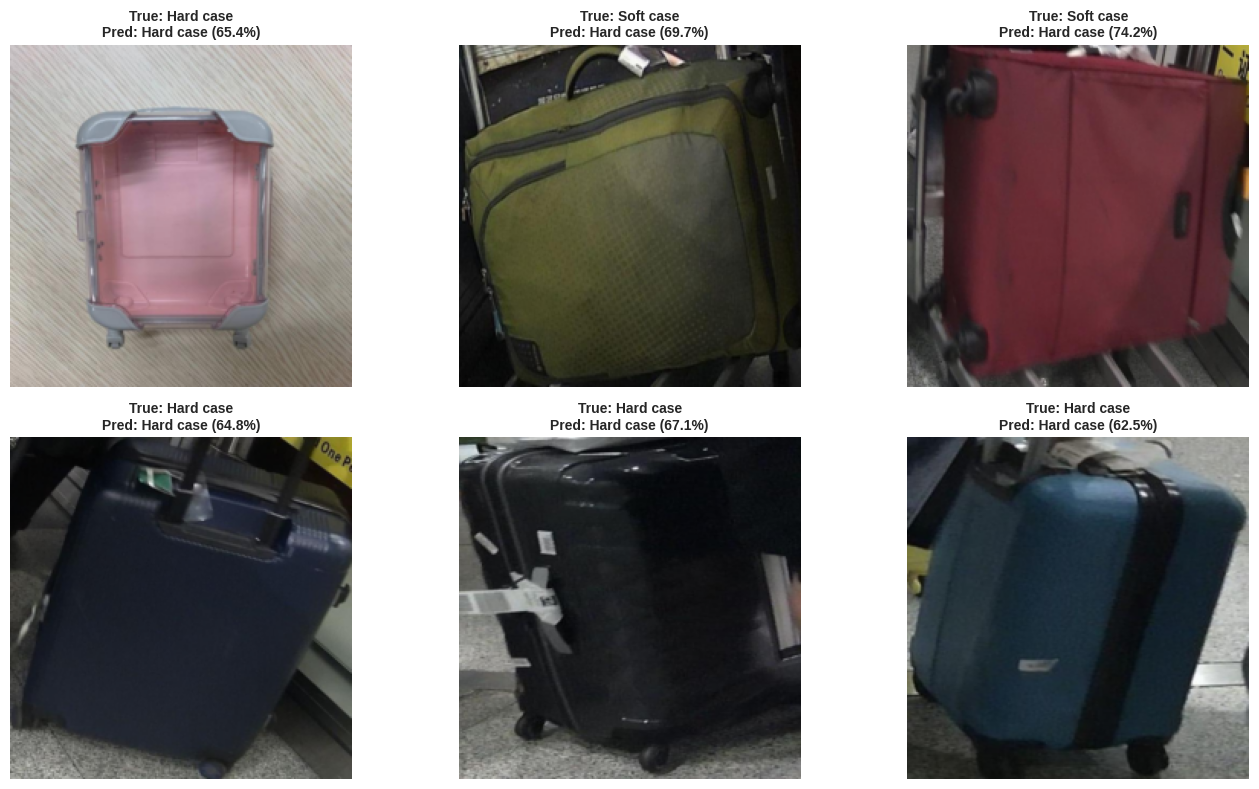

✓ Saved: /content/results/example_predictions.png


In [ ]:
cfg.DATA_DIR = "/content/luggage-universe-1"
dataset = val_loader.dataset

model.eval()
n = min(6, len(dataset))
idxs = random.sample(range(len(dataset)), n)

plt.figure(figsize=(14, 8))

for i, idx in enumerate(idxs, 1):
    img, true_label = dataset[idx]

    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
        conf = float(probs[pred]) * 100

    # unnormalize for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.subplot(2, 3, i)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred]} ({conf:.1f}%)",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.savefig(f"{cfg.RESULTS_DIR}/example_predictions.png", dpi=150, bbox_inches="tight")
plt.show()

print("✓ Saved:", f"{cfg.RESULTS_DIR}/example_predictions.png")